In [1]:
import pandas as pd

# Load the csv file into a DataFrame
file_path = '../Datasets/SPX.csv'
data = pd.read_csv(file_path, parse_dates=['Date'])
data.set_index('Date', inplace=True)

# Display the first few rows of the DataFrame
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,1845.859985,1845.859985,1827.739990,1831.979980,1831.979980,3080600000
2014-01-03,1833.209961,1838.239990,1829.130005,1831.369995,1831.369995,2774270000
2014-01-06,1832.310059,1837.160034,1823.729980,1826.770020,1826.770020,3294850000
2014-01-07,1828.709961,1840.099976,1828.709961,1837.880005,1837.880005,3511750000
2014-01-08,1837.900024,1840.020020,1831.400024,1837.489990,1837.489990,3652140000


In [6]:
import pandas as pd
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting import Backtest
from backtesting.test import SMA

# Load the csv file into a DataFrame
file_path = '../Datasets/SPX.csv'
data = pd.read_csv(file_path, parse_dates=['Date'])
data.set_index('Date', inplace=True)

def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std * std
    lower = mean - n_std * std
    return upper, lower

close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
upper, lower = BBANDS(data, 20, 2)

# Design matrix / independent features:
# Price-derived features
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close

# Indicator features
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close

# Convert the index to datetime
data.index = pd.to_datetime(data.index)

# Add sentiment feature
data['X_Sentiment'] = ~data.index.to_series().between('2017-09-27', '2017-12-14')

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data = data.dropna().astype(float)

# Display the first few rows of the DataFrame
print(data.head())


                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2014-05-27  1902.010010  1912.280029  1902.010010  1911.910034  1911.910034   
2014-05-28  1911.770020  1914.459961  1907.300049  1909.780029  1909.780029   
2014-05-29  1910.599976  1920.030029  1909.819946  1920.030029  1920.030029   
2014-05-30  1920.329956  1924.030029  1916.640015  1923.569946  1923.569946   
2014-06-02  1923.869995  1925.880005  1915.979980  1924.969971  1924.969971   

                  Volume   X_SMA10   X_SMA20   X_SMA50  X_SMA100  \
Date                                                               
2014-05-27  2.911020e+09  0.012215  0.014232  0.021227  0.032337   
2014-05-28  2.976450e+09  0.010468  0.012309  0.019602  0.030851   
2014-05-29  2.709050e+09  0.014110  0.016642  0.024338  0.035563   
2014-05-30  3.263490e+09  0.013183  0.017415  0.025481  0.036834   
2014-06-02  2.509020e+09  0.011454  0.

In [7]:
import numpy as np


def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(48).shift(-48)  # Returns after roughly two days
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

Classification accuracy:  0.6075949367088608


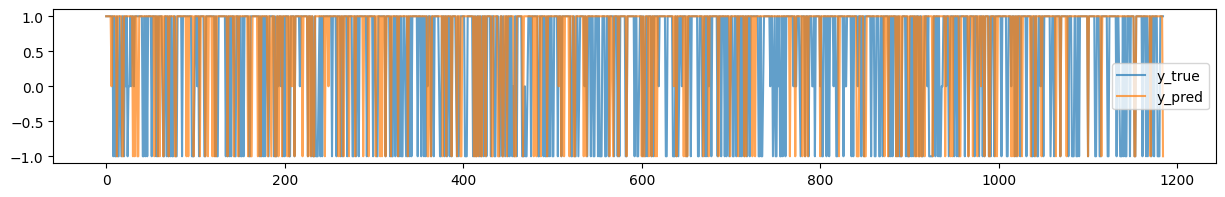

In [8]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

clf = KNeighborsClassifier(7)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

In [9]:
%%time

from backtesting import Backtest, Strategy

N_TRAIN = 400


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = KNeighborsClassifier(7)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()

CPU times: total: 2.25 s
Wall time: 2.25 s


Start                     2014-05-27 00:00:00
End                       2023-12-29 00:00:00
Duration                   3503 days 00:00:00
Exposure Time [%]                   45.593711
Equity Final [$]                   798.805601
Equity Peak [$]                  10187.176494
Return [%]                         -92.011944
Buy & Hold Return [%]              149.479839
Return (Ann.) [%]                  -23.163622
Volatility (Ann.) [%]                9.849648
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -92.230716
Avg. Drawdown [%]                  -46.865843
Max. Drawdown Duration     2916 days 00:00:00
Avg. Drawdown Duration     1462 days 00:00:00
# Trades                                  945
Win Rate [%]                        35.238095
Best Trade [%]                       0.878477
Worst Trade [%]                     -2.788474
Avg. Trade [%]                    

In [10]:
bt.plot()


C:\Users\23713\anaconda3\envs\pytorch\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\23713\anaconda3\envs\pytorch\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p1643', ...)

In [11]:
%%time

class MLWalkForwardStrategy(MLTrainOnceStrategy):
    def next(self):
        # Skip the cold start period with too few values available
        if len(self.data) < N_TRAIN:
            return

        # Re-train the model only every 20 iterations.
        # Since 20 << N_TRAIN, we don't lose much in terms of
        # "recent training examples", but the speed-up is significant!
        if len(self.data) % 20:
            return super().next()

        # Retrain on last N_TRAIN values
        df = self.data.df[-N_TRAIN:]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Now that the model is fitted, 
        # proceed the same as in MLTrainOnceStrategy
        super().next()


bt = Backtest(data, MLWalkForwardStrategy, commission=.0002, margin=.05)
bt.run()


CPU times: total: 2.64 s
Wall time: 2.63 s


Start                     2014-05-27 00:00:00
End                       2023-12-29 00:00:00
Duration                   3503 days 00:00:00
Exposure Time [%]                   49.110468
Equity Final [$]                   805.898701
Equity Peak [$]                  10187.176494
Return [%]                         -91.941013
Buy & Hold Return [%]              149.479839
Return (Ann.) [%]                  -23.092768
Volatility (Ann.) [%]               10.267245
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -92.089087
Avg. Drawdown [%]                  -46.795029
Max. Drawdown Duration     2916 days 00:00:00
Avg. Drawdown Duration     1462 days 00:00:00
# Trades                                  964
Win Rate [%]                        34.128631
Best Trade [%]                       0.897032
Worst Trade [%]                     -2.788474
Avg. Trade [%]                    

In [12]:
bt.plot()


C:\Users\23713\anaconda3\envs\pytorch\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\23713\anaconda3\envs\pytorch\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p3009', ...)